# Trennung Signal-Hintergrund - Features
Im vorherigen Jupyter-Notebook (JN) `sb01-yml2csv.ipynb` sind die Rohdaten für die Wellen aufbereitet worden 
und als CSV-Datei ausgegeben worden.
- In den Hintergrunddaten sind diejenigen Wellen eliminiert worden, bei denen der maximale (negative) Impuls
den Schwellwert von $8000$ überschritten haben. Damit ist die maximale Impulshöhe keine geeignete
Eigenschaft für das Training, da diese Eigenschaft für die Ermittlung der Trainingsdaten einen wesentlichen Einfluss hat.
- Darüber hinaus wurden diejenigen Wellen (bei den Signalen und beim Hintergrund) eliminiert,
deren maximaler Impuls zu weit am Rande des Aufnahmezeitraums von 100 Pixel lag.

Im JN `sb02-separate.ipynb` wird aus den 100-Pixel-Rohdaten neben einem Bereich ein Bereich von 25-Pixel um den maximalen (negativen) Impuls noch weitere Merkmale (*features*) herausgegriffen.
In diesem JN werden nun diese Merkmale untersucht und zur Trennung von Signal und Hintergrund herangezogen.

## 1. Vorbereitungen

In [1]:
# --- imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
import pandas as pd
import seaborn as sns 

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import time, timeit
from tools_confmatrix import show_confusion_matrix_extended, get_confusion_matrix_values, show_confusion_matrix_line
from tools_showwaves import show_waves
from general_parameters import LABEL_SIGNAL, LABEL_BACKGROUND, get_label, RANDOM_STATE

In [2]:
# --- parameters
filename_inp = "data\sbData.csv"

In [3]:
# --- load data from CSV-files
data_complete = np.loadtxt (filename_inp, delimiter=";", skiprows=1)
print ("data  ", data_complete.shape)
print ()

n_instances = len (data_complete)
print (f"number of instances: {n_instances:d}")

data   (23754, 137)

number of instances: 23754


In [4]:
df = pd.read_csv (filename_inp, delimiter=";", header=0)
df.head ()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,C23,C24,PEAK1,PEAK2,P2P_DIFF,P2P_RATIO,P2P_DIST,WIDTH1,WIDTH2,LABEL
0,-934.5,-79.5,1016.5,618.5,-1248.5,-2689.5,-2295.5,-896.5,-417.5,-1362.5,...,5669.33,4734.40,31865.5,16424.5,48290.0,1.94012,8.0,3.94794,14.4728,1.0
1,-1172.0,-541.0,633.0,816.0,-646.0,-2475.0,-2731.0,-1036.0,898.0,1199.0,...,11059.80,9063.25,32617.0,25513.0,58130.0,1.27845,8.0,4.45674,14.3032,1.0
2,-718.0,-698.0,361.0,1376.0,1626.0,1453.0,1436.0,1355.0,519.0,-918.0,...,6883.86,5327.40,32340.0,21550.0,53890.0,1.50070,9.0,5.11780,11.6681,1.0
3,2874.5,2649.5,771.5,-746.5,-938.5,-441.5,-175.5,-177.5,10.5,323.5,...,9307.59,8193.37,16858.5,7470.5,24329.0,2.25668,13.0,4.65325,15.5514,1.0
4,-898.0,-53.0,1334.0,2076.0,1579.0,461.0,-180.0,-45.0,156.0,-199.0,...,5265.13,4464.54,32376.0,15214.0,47590.0,2.12804,11.0,4.60859,12.9522,1.0


## 2 Die wichtigen Merkmale
Die nachfolgenden Kennzeichen werden in die weitere Untersuchung und Bearbeitung einbezogen. Für die klassichen ML-Algorithmen wird der maximale (negative) Impuls (im Folgenden *MaxPuls* genannt)
und der nachfolgende nächste maximale (positive) Impuls (im Folgenden *NextPuls* genannt) untersucht. 
- `PEAK1`: (positive) Höhe von *MaxPuls*
- `PEAK2`: Höhe von *NextPuls*
- `P2P_DIFF`: die vertikale Differenz zwischen MaxPuls und NextPuls
- `P2P_RATIO`: das Verhältnis zwischen den Höhen zwischen MaxPuls und NextPuls
- `P2P_DIST`: die horizontale Distanz zwischen MaxPuls und NextPuls
- `WIDTH1`: die Breite des Impulses auf halben Impulshöhe, beim MaxPuls
- `WIDTH2`: die Breite des Impulses auf halben Impulshöhe, beim NextPuls

In [5]:
# --- prepare the learning set plus additional information
#     --- parameter setting
row_indices = [100] + list (range (129, 137))
data = data_complete [:,row_indices]
#data_features = data_complete [:,row_indices [:-1]]
#data_label = data_complete [:,-1]
n_instances = len (data)

print ("data      : ", data.shape)
#print ("features : ", data_features.shape)
#print ("label    : ", data_label.shape)
print ("number of instances : ", n_instances)

data      :  (23754, 9)
number of instances :  23754


In [6]:
# --- print the first rows of the data
def print_line (feat):
    #print (features, label)
    print (f"{int(feat [0]):5d}  {feat[1]:8.2f}  {feat[2]:8.2f}  {feat[3]:8.2f}  {feat[4]:8.4f}", end="")
    print (f"  {int(feat[5]):3d}      {feat[6]:8.4f}  {feat[7]:8.4f}", end="")
    print (f"    {get_label(int(feat [8])):s}")
    
print (f"INDEX  PEAK1     PEAK2     P2P_DIFF  P2P_RATIO P2P_DIST  WIDTH1    WIDTH2    LABEL")
n_prints = 10
for i in range (n_prints):
    ind = np.random.randint (0, n_instances + 1)
    print_line (data [ind])

INDEX  PEAK1     PEAK2     P2P_DIFF  P2P_RATIO P2P_DIST  WIDTH1    WIDTH2    LABEL
 6279  11267.50   6343.50  17611.00    1.7762    7        5.7339    9.2717    signal    
19555   7512.00   3306.00  10818.00    2.2722   13        3.6214    3.4450    background
14449  15641.00   7182.00  22823.00    2.1778    9        4.5166   10.6235    signal    
21368   7440.00   2653.00  10093.00    2.8044    3        3.2756    3.1226    background
 1341  32230.00  30100.00  62330.00    1.0708    9        5.1981   13.1182    signal    
20855   7233.50   3172.50  10406.00    2.2801   19        3.6810    8.4548    background
12065  10397.50   5519.50  15917.00    1.8838   10        4.5046    9.0930    signal    
15411   7422.50   3694.50  11117.00    2.0091    4        3.5988    3.2078    background
19672   7035.50   3461.50  10497.00    2.0325   20        4.3495    4.0528    background
 4148  28322.00  15378.00  43700.00    1.8417    8        4.0619   12.8467    signal    


Histogramm für `PEAK1`, getrennt nach `LABEL`

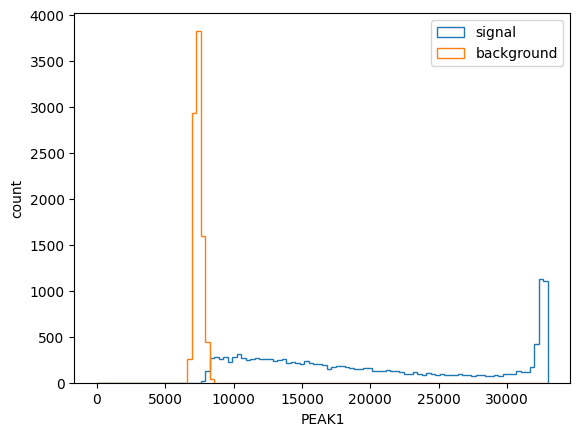

In [7]:
peak1_s = data [np.where (data [:, -1] == LABEL_SIGNAL), 1]
peak1_b = data [np.where (data [:, -1] == LABEL_BACKGROUND), 1]
plt.hist (peak1_s [0], bins = 100, range =[0.0, 33000.0], histtype='step', label='signal')
plt.hist (peak1_b [0], bins = 100, range =[0.0, 33000.0], histtype='step', label='background')
plt.xlabel ("PEAK1")
plt.ylabel ("count")
plt.legend ()
plt.show ()

Histogramm für `P2P_DIFF`, getrennt nach `LABEL`

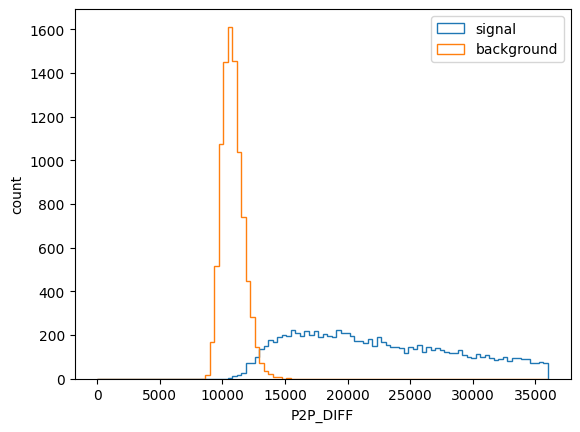

In [8]:
p2p_diff_s = data [np.where (data [:, -1] == LABEL_SIGNAL), 3]
p2p_diff_b = data [np.where (data [:, -1] == LABEL_BACKGROUND), 3]
plt.hist (p2p_diff_s [0], bins = 100, range =[0.0, 36000.0], histtype='step', label='signal')
plt.hist (p2p_diff_b [0], bins = 100, range =[0.0, 36000.0], histtype='step', label='background')
plt.xlabel ("P2P_DIFF")
plt.ylabel ("count")
plt.legend ()
plt.show ()

Die maximale (negative) Impulshöhe wurde als Filterkriterium bei den Daten des Hintergrunds angewendet. Daher steckt in den Merkmalen `PEAK1`und auch `P2P_DIFF` Informationen, so dass diese Daten nicht mehr unabhängig als Lerndaten verwendet werden können.

### Pair-Picture
FÜr die vier weiteren Merkmale `P2P_RATIO`, `P2P_DIST`, `WIDTH1` und `WIDTH2` werden die Pair-Pictures erstellt.

In [9]:
df1 = df[["P2P_RATIO","P2P_DIST","WIDTH1","WIDTH2","LABEL"]]
df1.head()

,P2P_RATIO,P2P_DIST,WIDTH1,WIDTH2,LABEL
0,1.94012,8.0,3.94794,14.4728,1.0
1,1.27845,8.0,4.45674,14.3032,1.0
2,1.50070,9.0,5.11780,11.6681,1.0
3,2.25668,13.0,4.65325,15.5514,1.0
4,2.12804,11.0,4.60859,12.9522,1.0


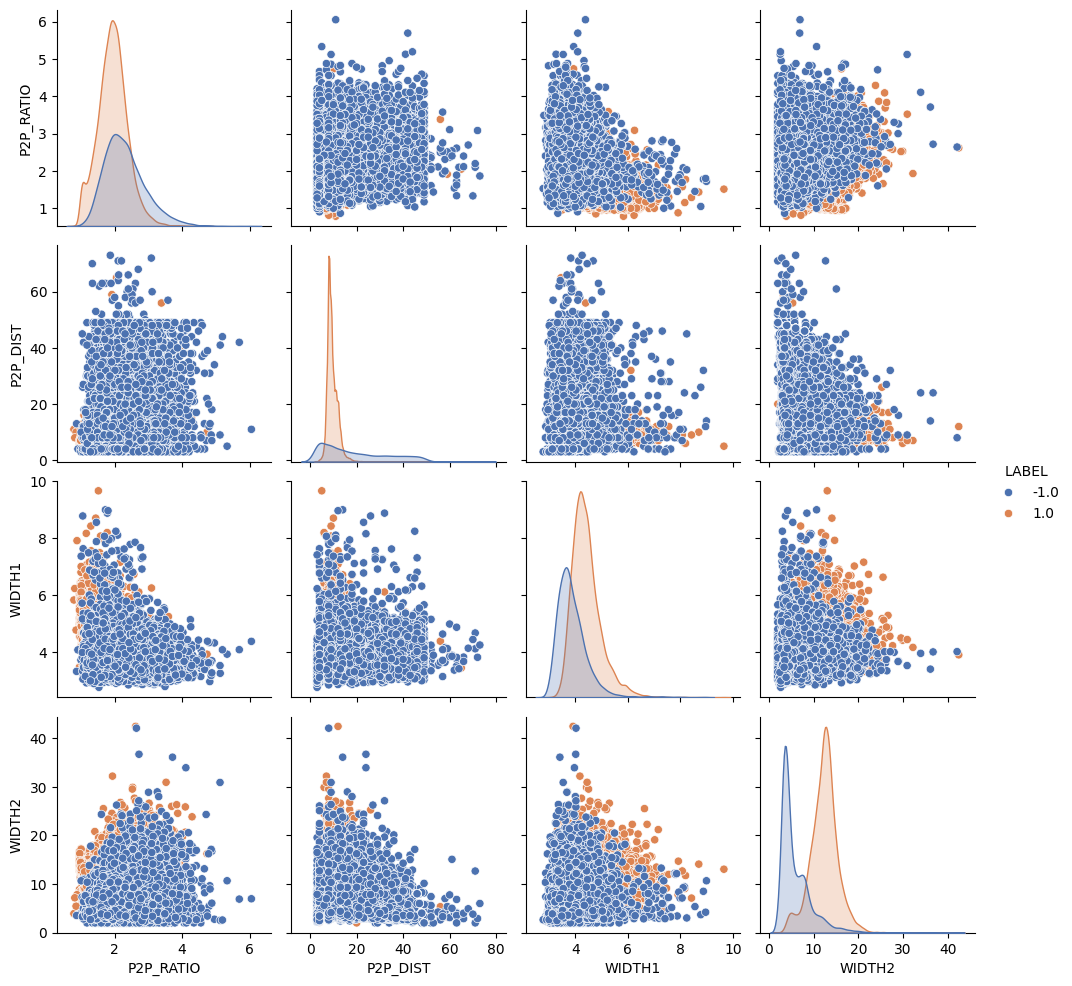

In [10]:
sns.pairplot (df1, hue="LABEL", palette="deep")

## Trainings- und Testdaten erstellen

In [11]:
row_indices = [0] + list (range (4, 8))
data_features = data [:,row_indices]
data_label = data [:,-1]

In [12]:
# --- split in training set / test set
test_size = 0.25
X_train_plus, X_test_plus, y_train, y_test \
    = train_test_split (data_features, data_label, test_size=test_size, random_state=RANDOM_STATE)
X_train = X_train_plus [:,1:]  # eleminate INDEX
X_test = X_test_plus [:,1:]    # eleminate INDEX

print (f"Elements in the training set   : {X_train.shape [0]:5d}")
unique, counts = np.unique (y_train, return_counts = True)
print (f"  thereof signals              : {counts [1]:5d}")
print (f"Elements in the test set       : {X_test.shape [0]:5d}")
unique, counts = np.unique (y_test, return_counts = True)
print (f"  thereof signals              : {counts [1]:5d}")

print ("data_features: ", data_features.shape)
print ("X_train_plus : ", X_train_plus.shape)
print ("X_train      : ", X_train.shape)


Elements in the training set   : 17815
  thereof signals              : 10987
Elements in the test set       :  5939
  thereof signals              :  3679
data_features:  (23754, 5)
X_train_plus :  (17815, 5)
X_train      :  (17815, 4)


## 3 klassische ML-Algorithmen (DT und kNN)
In diesem Abschnitt wird untersucht, wie klassische ML-Algorithmen mit den vier Merkmalen umgehen können.

### 3.1 DT

In [13]:
from sklearn import metrics 

# --- define model
DT_model = DecisionTreeClassifier (random_state=RANDOM_STATE)
print (DT_model)

# --- fit (train)
DT_model.fit (X_train, y_train)

# --- predict
y_pred = DT_model.predict (X_test)

show_confusion_matrix_extended (y_test, y_pred, labels = ["background", "signal"])

DecisionTreeClassifier(random_state=42)
  Confusion Matrix       |     predicted label     |
                         | background | signal     |
-------------------------+------------+------------+
              background | TN=   1956 | FP=    304 |
  true label  -----------+------------+------------+
              signal     | FN=    301 | TP=   3378 |
-------------------------+------------+------------+

    F1-score    = 0.9178
    accuracy    = 0.8981
    precision   = 0.9174    purity
    recall      = 0.9182    sensitivity / efficiency
    FP-rate     = 0.1345    alpha-error
    TP-rate     = 0.9182    1 - beta-error


### 3.2 kNN

In [14]:
from sklearn import neighbors
model_kNN = neighbors.KNeighborsClassifier(n_neighbors = 3)

# --- train the model
model_kNN.fit (X_train, y_train)

# --- predict the test set
y_pred = model_kNN.predict (X_test)

show_confusion_matrix_extended (y_test, y_pred, labels = ["background", "signal"])

  Confusion Matrix       |     predicted label     |
                         | background | signal     |
-------------------------+------------+------------+
              background | TN=   1991 | FP=    269 |
  true label  -----------+------------+------------+
              signal     | FN=    192 | TP=   3487 |
-------------------------+------------+------------+

    F1-score    = 0.9380
    accuracy    = 0.9224
    precision   = 0.9284    purity
    recall      = 0.9478    sensitivity / efficiency
    FP-rate     = 0.1190    alpha-error
    TP-rate     = 0.9478    1 - beta-error


In [15]:
print ("key figures              TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1")
for k in [3, 5, 7, 9, 11, 13, 15, 17]:
    model_kNN = neighbors.KNeighborsClassifier(n_neighbors = k)
    model_kNN.fit (X_train, y_train)
    y_pred = model_kNN.predict (X_test)
    print (f"kNN #neighbours : {k:2d}", end="")
    show_confusion_matrix_line (y_test, y_pred, asLaTeX=False)

key figures              TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1
kNN #neighbours :  3   3487     192     269    1991  0.9224  0.9284  0.9478  0.1190  0.9478  0.9380
kNN #neighbours :  5   3510     169     262    1998  0.9274  0.9305  0.9541  0.1159  0.9541  0.9422
kNN #neighbours :  7   3508     171     268    1992  0.9261  0.9290  0.9535  0.1186  0.9535  0.9411
kNN #neighbours :  9   3515     164     265    1995  0.9278  0.9299  0.9554  0.1173  0.9554  0.9425
kNN #neighbours : 11   3515     164     259    2001  0.9288  0.9314  0.9554  0.1146  0.9554  0.9432
kNN #neighbours : 13   3517     162     265    1995  0.9281  0.9299  0.9560  0.1173  0.9560  0.9428
kNN #neighbours : 15   3515     164     261    1999  0.9284  0.9309  0.9554  0.1155  0.9554  0.9430
kNN #neighbours : 17   3519     160     260    2000  0.9293  0.9312  0.9565  0.1150  0.9565  0.9437


## 4 ML-Algorithmus: Logistics Regression
Als erstes wird eine Logistische Regression für die binäre Klassifikation angewendet.

In [16]:
# --- standard scaling
scaler = StandardScaler ()
X_train_scaled = scaler.fit_transform (X_train)
X_test_scaled = scaler.fit_transform (X_test)

# --- train logistics regression
log_reg = LogisticRegression (max_iter=1000, solver='lbfgs') 
log_reg.fit (X_train_scaled, y_train) 

LogisticRegression(max_iter=1000)

Nun wird die ROC-Kurve ermittelt und geplottet.

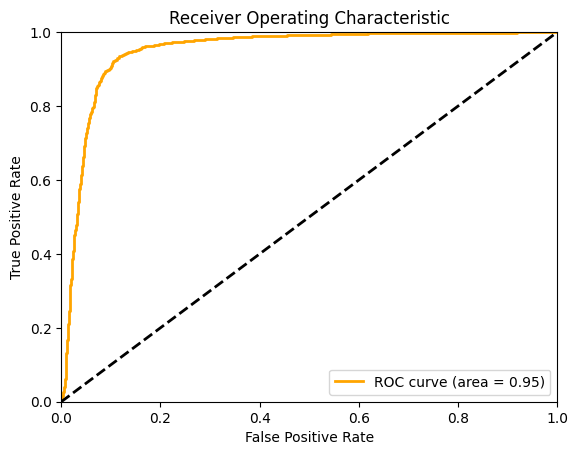

AUC: 0.949280537468098


In [17]:
# --- determine ROC and AUC
y_pred_prob = log_reg.predict_proba (X_test_scaled)[:, 1] 

def show_roc (y_pred, y_test):
    fpr, tpr, thresholds = roc_curve (y_test, y_pred) 
    roc_auc = roc_auc_score (y_test, y_pred)

    # --- plot ROC 
    plt.figure()
    plt.plot (fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot ([0, 1], [0, 1], color='black', lw=2, linestyle='--') 
    plt.xlim ([0.0, 1.0]) 
    plt.ylim ([0.0, 1.0]) 
    plt.xlabel ('False Positive Rate') 
    plt.ylabel ('True Positive Rate') 
    plt.title ('Receiver Operating Characteristic') 
    plt.legend (loc="lower right") 
    plt.show () 
    print ("AUC:", roc_auc)

show_roc (y_pred_prob, y_test)

In [18]:
# --- determine 
y_pred_log_reg = log_reg.predict (X_test_scaled)
show_confusion_matrix_extended (y_test, y_pred_log_reg)

  Confusion Matrix       |     predicted label     |
                         | Neg        | Pos        |
-------------------------+------------+------------+
              Neg        | TN=   1935 | FP=    325 |
  true label  -----------+------------+------------+
              Pos        | FN=    191 | TP=   3488 |
-------------------------+------------+------------+

    F1-score    = 0.9311
    accuracy    = 0.9131
    precision   = 0.9148    purity
    recall      = 0.9481    sensitivity / efficiency
    FP-rate     = 0.1438    alpha-error
    TP-rate     = 0.9481    1 - beta-error


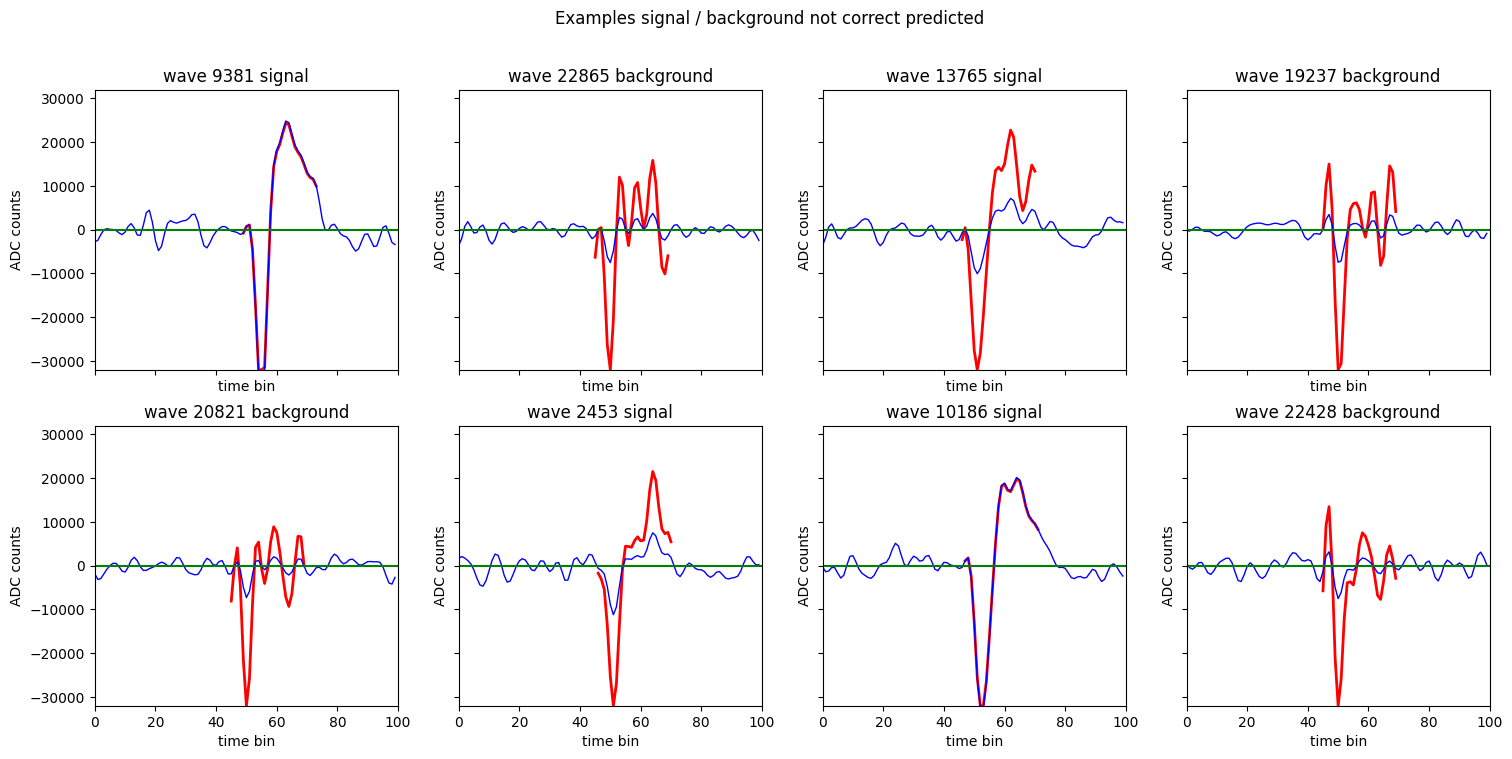

In [19]:
def show_wrong_predicted (y_pred, y_true, X_test_plus, data_complete):
    diff_indices = np.where (np.not_equal (y_pred, y_true))[0]
    wrong_prediction = (X_test_plus [diff_indices,0]).astype (int)

    title = "Examples signal / background not correct predicted"
    figsize = (18.,8.)
    items = np.random.choice (wrong_prediction, size=8, replace=False)
    show_waves (data_complete, title, n_cols=4, n_rows=2, source="defined", items=items, figsize=figsize, \
            withLabel=True, withIndex=True, withOrg=True, withContour=True, withAxisLabelling=True, withZeroLine=True)
    return wrong_prediction

wrong_log_reg = show_wrong_predicted (y_pred_log_reg, y_test, X_train_plus, data_complete)

## 5 ML-Algorithmus: Perceptron

In [20]:
perceptron = Perceptron () 
perceptron.fit (X_train_scaled, y_train) 
y_pred_perc = perceptron.predict (X_test_scaled) 
show_confusion_matrix_extended (y_test, y_pred_perc)

  Confusion Matrix       |     predicted label     |
                         | Neg        | Pos        |
-------------------------+------------+------------+
              Neg        | TN=   1563 | FP=    697 |
  true label  -----------+------------+------------+
              Pos        | FN=    243 | TP=   3436 |
-------------------------+------------+------------+

    F1-score    = 0.8797
    accuracy    = 0.8417
    precision   = 0.8314    purity
    recall      = 0.9339    sensitivity / efficiency
    FP-rate     = 0.3084    alpha-error
    TP-rate     = 0.9339    1 - beta-error


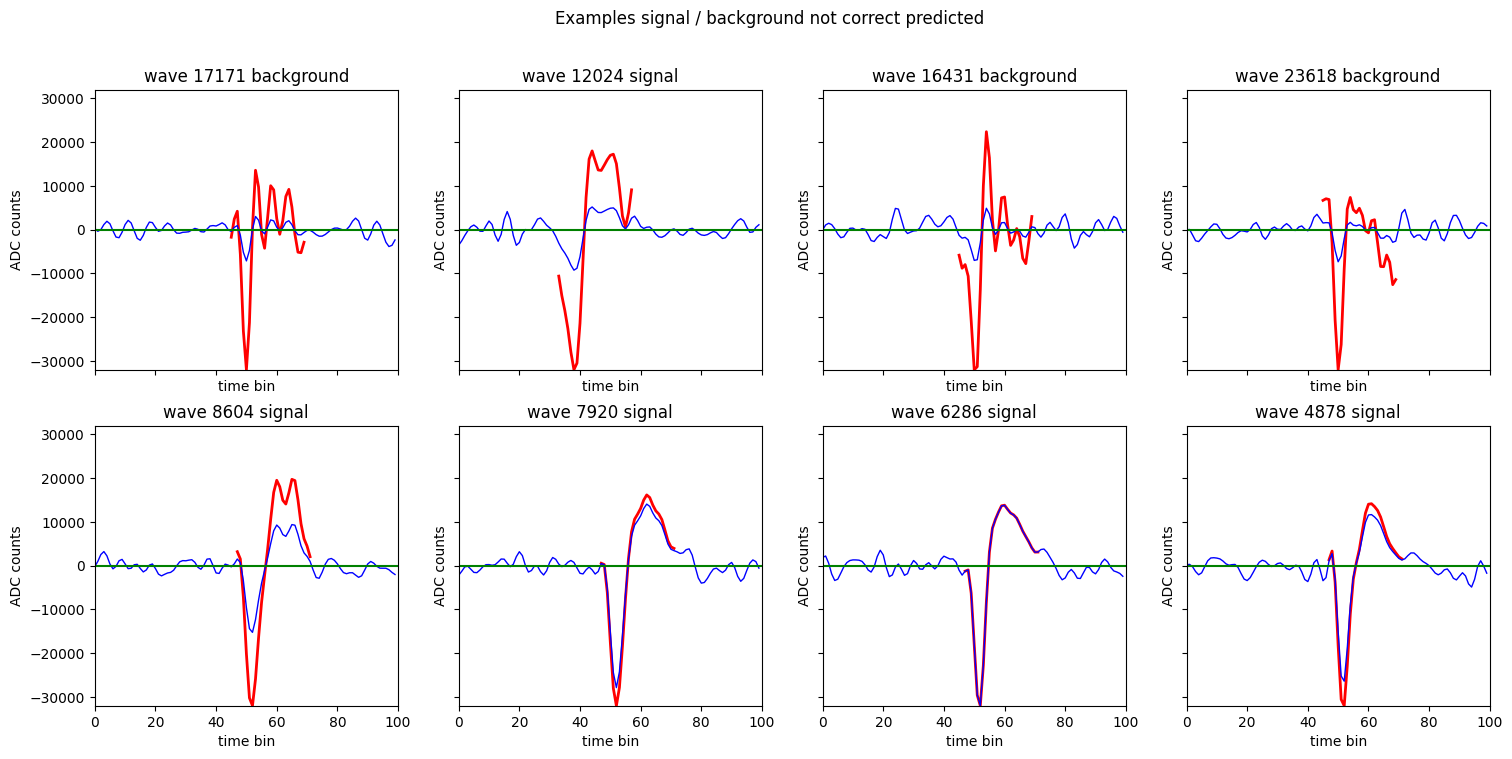

In [21]:
wrong_perc = show_wrong_predicted (y_pred_perc, y_test, X_train_plus, data_complete)

## 6 ML-Algorithmus: Neuronales Netz
Es wird nun ein einfaches Neuronales Netz definiert. 
Dazu wird der `MLPClassifier`von `scikit-learn` verwendet.
Als Einstellungen werden (außer bei der Anzahl der Neuron in den versteckten Layern), die Standardeinstellungen verwendet, beispielsweise:
- Aktivierungsfunktion: `relu`
- Lösungsverfahren: `adam`
Neben dem Eingabe-Layer mit 25 Neuronen und dem Ausgabe-Layer mit 2 Neuronen
gibt es versteckte Layer. Für die Größe des Layers werden verschiedene Werte getestet.

Die Daten wurden schon bei der Aufbereitung der Daten skaliert, so dass der maximale (negative) Impuls den Wert -1 hat.

## Erstes Layerdesign

In [22]:
def neunet (X_train, X_test, y_train, y_test, layer_size, max_iter, prot_Short = True, with_train=True):

    # --- define the ML-algorithm
    mlp = MLPClassifier (hidden_layer_sizes=layer_size, max_iter=max_iter, random_state=RANDOM_STATE)

    # --- train the ML-algorithm
    y_train_reshape = y_train.reshape (y_train.size, )
    mlp.fit (X_train, y_train_reshape)

    # --- apply the ML-algorithm to the test data
    y_pred = mlp.predict (X_test)
    y_pred_train = mlp.predict (X_train)

    # --- display results
    layer_size_text = f"{layer_size}"
    if (prot_Short == True):  # --- show figures in one line 
        print (f"{layer_size_text:12s}  test  ", end="")
        show_confusion_matrix_line (y_test, y_pred)
        if with_train:
            print (f"{layer_size_text:12s}  train ", end="")
            show_confusion_matrix_line (y_train, y_pred_train)
    else: 
        print ("Layer-Size : ", layer_size)
        print ("Results test-data")
        show_confusion_matrix_extended (y_test, y_pred, labels = ["background", "signal"])
        print ()
        if with_train:
            print ("Results train-data")
            show_confusion_matrix_extended (y_train, y_pred_train, labels = ["background", "signal"])
            print ()

    return y_pred

In [23]:
layer_size = (4,)
max_iter = 10000
neunet (X_train_scaled, X_test_scaled, y_train, y_test, layer_size, max_iter, prot_Short=False, with_train=False)

print ("key figures              TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1")
y_pred_nn_4 = neunet (X_train_scaled, X_test_scaled, y_train, y_test, layer_size, max_iter, prot_Short=True, with_train=True)

Layer-Size :  (4,)
Results test-data
  Confusion Matrix       |     predicted label     |
                         | background | signal     |
-------------------------+------------+------------+
              background | TN=   1998 | FP=    262 |
  true label  -----------+------------+------------+
              signal     | FN=    157 | TP=   3522 |
-------------------------+------------+------------+

    F1-score    = 0.9439
    accuracy    = 0.9294
    precision   = 0.9308    purity
    recall      = 0.9573    sensitivity / efficiency
    FP-rate     = 0.1159    alpha-error
    TP-rate     = 0.9573    1 - beta-error

key figures              TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1
(4,)          test     3522     157     262    1998  0.9294  0.9308  0.9573  0.1159  0.9573  0.9439
(4,)          train   10510     477     763    6065  0.9304  0.9323  0.9566  0.1117  0.9566  0.9443


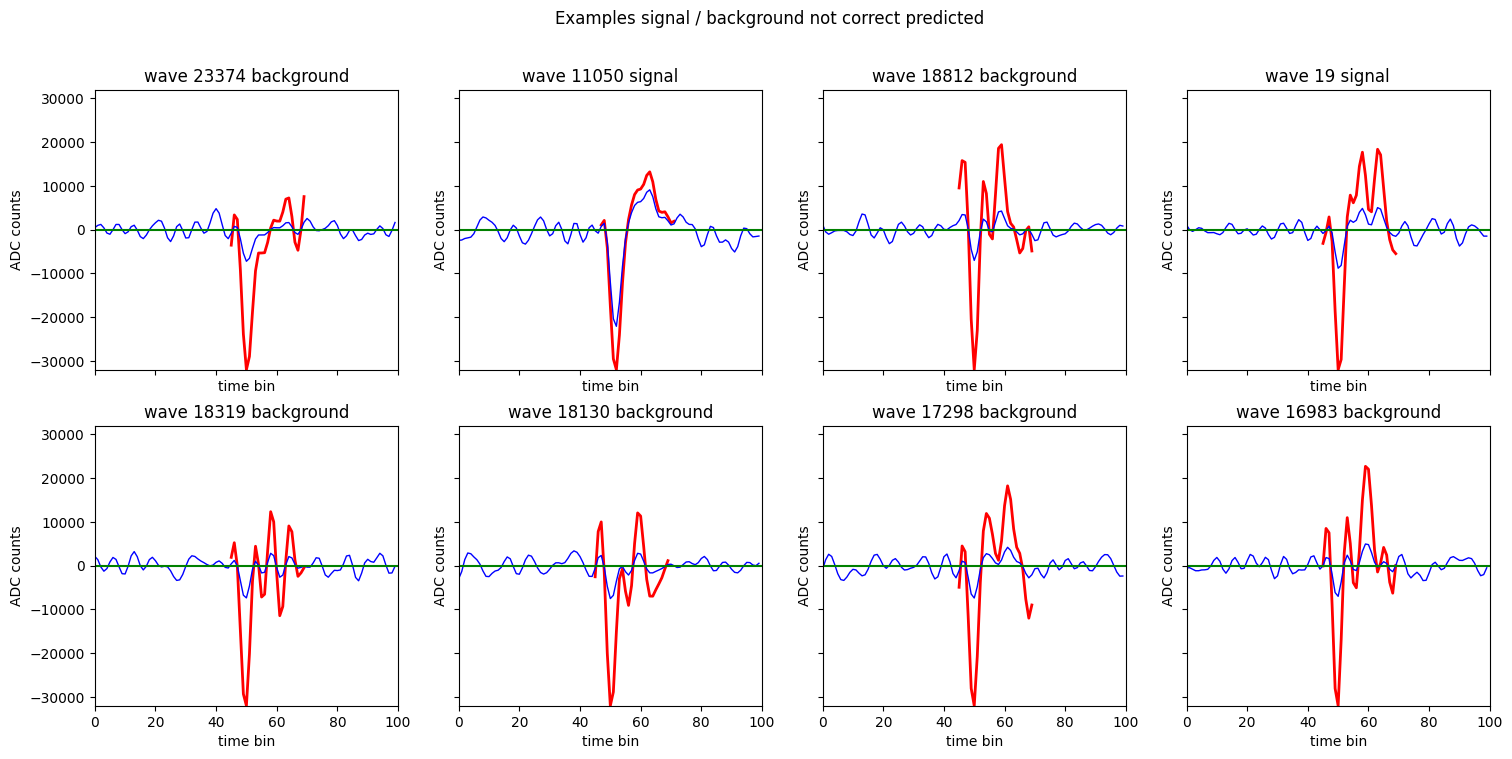

In [24]:
wrong_nn_4 = show_wrong_predicted (y_pred_nn_4, y_test, X_train_plus, data_complete)

### Lernkurve bestimmen

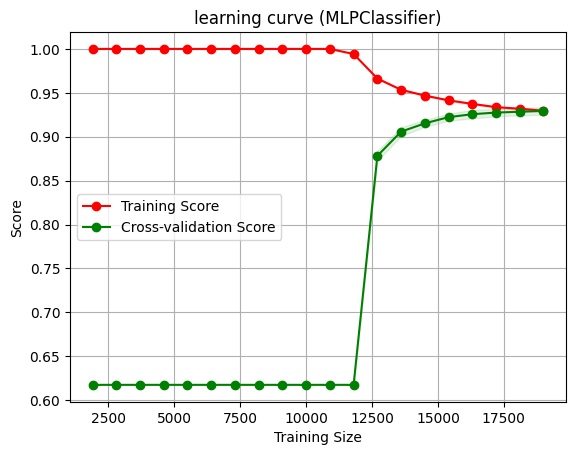

In [25]:
# Lernkurve berechnen 
#X_train_lc = scaler.transform (data_features [:,1:])
X_train_lc_a = data_features [:,1:]
y_train_lc = data_label
# --- standard scaling
scaler = StandardScaler ()
X_train_lc = scaler.fit_transform (X_train_lc_a)

layer_size = (4,)
max_iter = 10000
mlp = MLPClassifier (hidden_layer_sizes=layer_size, max_iter=max_iter, random_state=RANDOM_STATE)
train_sizes, train_scores, test_scores = learning_curve (mlp, X_train_lc, y_train_lc, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 20)) 
# --- calculate mean and std of traing and test accuracy 
train_scores_mean = np.mean (train_scores, axis=1) 
train_scores_std = np.std (train_scores, axis=1) 
test_scores_mean = np.mean (test_scores, axis=1) 
test_scores_std = np.std (test_scores, axis=1)

# --- plot learning curve
plt.figure() 
plt.title ("learning curve (MLPClassifier)") 
plt.xlabel ("Training Size") 
plt.ylabel ("Score") 
plt.grid() 

plt.fill_between (train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r") 
plt.fill_between (train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g") 

plt.plot (train_sizes, train_scores_mean, 'o-', color="r", label="Training Score") 
plt.plot (train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score") 
plt.legend (loc="best") 
plt.show()

### Anwendung CV für verschiedene Layerdesigns
Im Nachfolgenden werden verschiedene Layer-Strukturen durchgearbeitet. Dabei wird mittels Cross Validation, die gesammten Lerndaten bearbeitet.
Es wird ein Neronales Netz angewendet.

In [26]:
k_splits = 10
cv = KFold (shuffle = True, n_splits = k_splits, random_state=RANDOM_STATE)

def print_distribution (train, test, label):
    unique, counts = np.unique (label [train], return_counts=True)
    #print (unique)
    n_train_signal = counts [1]
    n_train_background = counts [0]
    unique, counts = np.unique (label [test], return_counts=True)
    n_test_signal = counts [1]
    n_test_background = counts [0]
    print (f" train [{n_train_signal:6.0f} - {n_train_background:6.0f}]", end = "")
    print (f"  test [{n_test_signal:6.0f} - {n_test_background:6.0f}]")

for train, test in cv.split (X_train_lc, y_train_lc):
    print_distribution (train, test, y_train_lc)


 train [ 13208 -   8170]  test [  1458 -    918]
 train [ 13186 -   8192]  test [  1480 -    896]
 train [ 13214 -   8164]  test [  1452 -    924]
 train [ 13189 -   8189]  test [  1477 -    899]
 train [ 13187 -   8192]  test [  1479 -    896]
 train [ 13189 -   8190]  test [  1477 -    898]
 train [ 13198 -   8181]  test [  1468 -    907]
 train [ 13190 -   8189]  test [  1476 -    899]
 train [ 13235 -   8144]  test [  1431 -    944]
 train [ 13198 -   8181]  test [  1468 -    907]


In [27]:
def print_scores (scores, scoring):
    print ("scoring: ", scoring)
    print ("test set  : ", end = "")
    for score in scores ['test_score']:
        print (f"  {score:6.4f}", end = "")
    print ()
    print ("train set : ", end = "")
    for score in scores ['train_score']:
        print (f"  {score:6.4f}", end = "")
    print ()

    print (f"{scoring:s} training set: {scores ['train_score'].mean():6.4f} +/- {scores ['train_score'].std():6.4f}")
    print (f"{scoring:s} test     set: {scores ['test_score'].mean():6.4f} +/- {scores ['test_score'].std():6.4f}")


#layer_sizes = [(25,), (20,), (15,), (10,), (5,), (4,), (3,), (2,), (15,5), (15,10), (15,15), (10, 5), (15,10,5)]
layer_sizes = [(4,), (5,), (10), (4,4)]
max_iter = 10000
#prot_Short
#if (prot_Short):
#    print ("key figures              TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1")
scoring='accuracy'
for layer_size in layer_sizes:
    print ("layer size: ", layer_size)
    start_time = time.time ()
    mlp_model = MLPClassifier (hidden_layer_sizes=layer_size, max_iter=max_iter, random_state=RANDOM_STATE)
    scores = cross_validate (mlp_model, X_train_lc, y_train_lc, cv=cv, scoring=scoring, return_train_score = True)
    end_time = time.time ()
    elapsed_time = end_time - start_time
    print_scores (scores, scoring)
    print (f"time used : {elapsed_time:6.1f} s")
    print ()


layer size:  (4,)
scoring:  accuracy
test set  :   0.9230  0.9339  0.9373  0.9310  0.9301  0.9314  0.9309  0.9318  0.9251  0.9288
train set :   0.9315  0.9297  0.9295  0.9295  0.9308  0.9302  0.9304  0.9299  0.9305  0.9310
accuracy training set: 0.9303 +/- 0.0006
accuracy test     set: 0.9303 +/- 0.0039
time used :   23.3 s

layer size:  (5,)
scoring:  accuracy
test set  :   0.9272  0.9327  0.9377  0.9318  0.9322  0.9301  0.9326  0.9347  0.9288  0.9326
train set :   0.9338  0.9331  0.9310  0.9324  0.9326  0.9326  0.9322  0.9321  0.9322  0.9325
accuracy training set: 0.9324 +/- 0.0007
accuracy test     set: 0.9321 +/- 0.0028
time used :   36.8 s

layer size:  10
scoring:  accuracy
test set  :   0.9331  0.9348  0.9432  0.9318  0.9331  0.9331  0.9331  0.9335  0.9326  0.9322
train set :   0.9342  0.9342  0.9343  0.9347  0.9339  0.9339  0.9345  0.9348  0.9342  0.9355
accuracy training set: 0.9344 +/- 0.0005
accuracy test     set: 0.9340 +/- 0.0031
time used :   49.6 s

layer size:  (4, 4)
s

In [28]:
layer_sizes = [(4,), (5,), (10,), (4, 4)]
#layer_sizes = [(5,)]
max_iter = 10000
#print ("key figures              rec       time ")
prot_Short = True
if (prot_Short):
    print ("key figures      TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1")

for layer_size in layer_sizes:
    layer_size_text = f"{layer_size}"
    print (f"{layer_size_text:12s}", end = "")
    start_time = time.time ()
    mlp_model = MLPClassifier (hidden_layer_sizes=layer_size, max_iter=max_iter, random_state=RANDOM_STATE)
    mlp_model.fit (X_train, y_train)
    end_time = time.time ()
    elapsed_time = end_time - start_time
    y_pred = mlp_model.predict (X_test)
    show_confusion_matrix_line (y_test, y_pred, with_time=True, elapsed_time=elapsed_time, asLaTeX=False)

key figures      TP      FN      FP      TN  acc     pre     rec     FPR     TPR     F1
(4,)           3527     152     271    1989  0.9288  0.9286  0.9587  0.1199  0.9587  0.9434     4.8 s
(5,)           3524     155     276    1984  0.9274  0.9274  0.9579  0.1221  0.9579  0.9424     2.9 s
(10,)          3491     188     318    1942  0.9148  0.9165  0.9489  0.1407  0.9489  0.9324     3.4 s
(4, 4)         3533     146     277    1983  0.9288  0.9273  0.9603  0.1226  0.9603  0.9435     6.2 s


### Wellen die bei allen drei Verfahren falsch zugeordnet sind

number of wrong predictions with all 3 methods:  269
[  146   309   398   448   470   472   494   601   611   762   763   764
   820   833   874   914   944  1514  1579  1594  1621  1829  1835  1916
  2058  2310  2341  2441  2574  2613  2633  2662  2726  2742  3066  3097
  3099  3260  3287  3307  3379  3459  3462  3477  3478  3484  3524  3538
  3692  3859  3905  4051  4100  4130  4162  4169  4356  4741  4866  4941
  4948  4999  5142  5236  5250  5314  5541  5553  5647  5673  5718  5861
  5893  6004  6056  6074  6115  6174  6274  6286  6492  6541  6798  6817
  6840  7038  7161  7185  7203  7361  7484  7488  7571  7609  7676  7802
  7814  7921  7975  8049  8115  8129  8360  8452  8481  8530  8784  8865
  9075  9086  9197  9246  9293  9418  9478  9543  9660  9711 10036 10056
 10186 10356 10466 10722 11000 11050 11106 11305 11346 11379 11423 11438
 11520 11584 11611 11923 12020 12024 12034 12044 12064 12077 12092 12272
 12371 12425 12469 12549 13144 13220 13274 13295 13346 13722 13735 1380

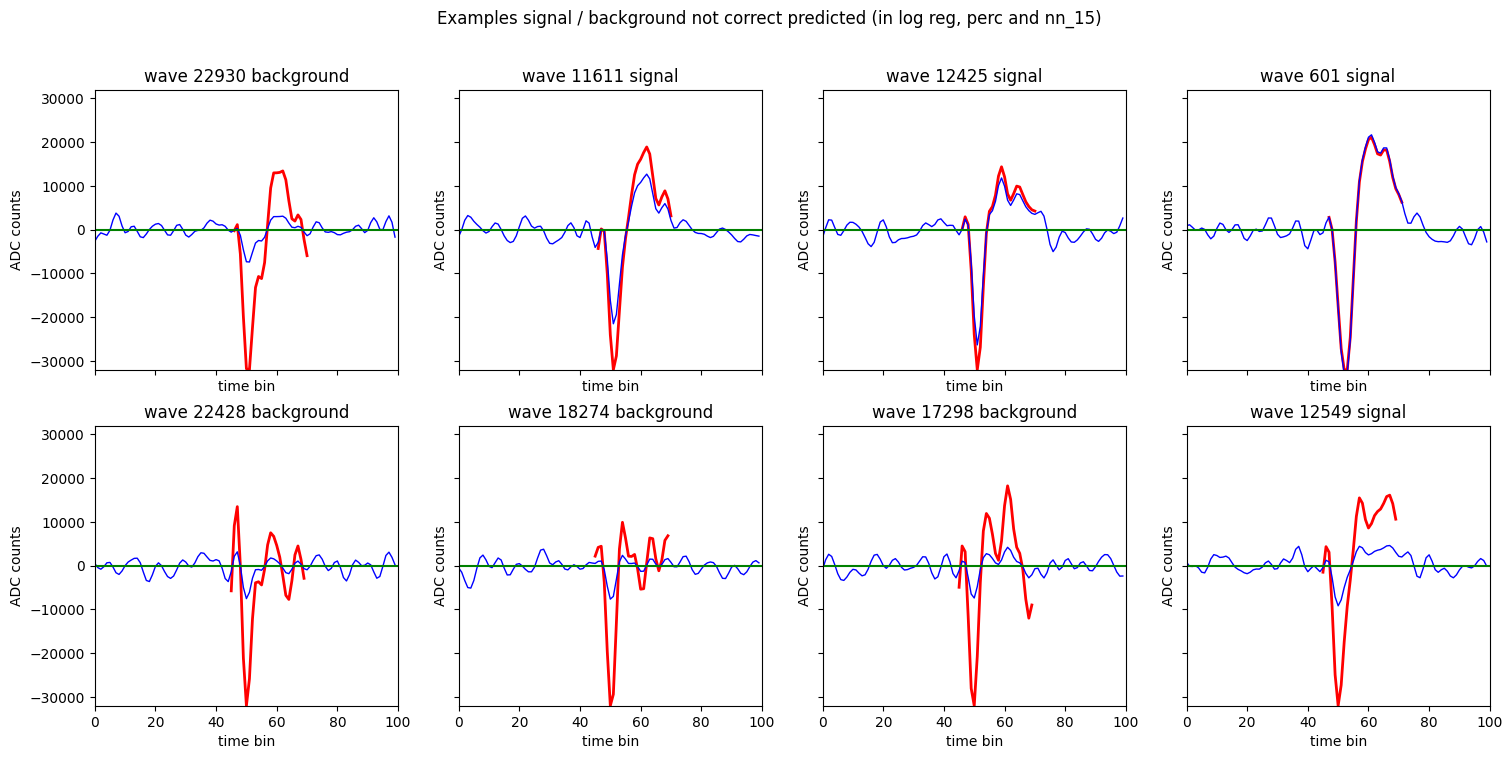

In [29]:
wrong = np.intersect1d (np.intersect1d (wrong_log_reg, wrong_perc), wrong_nn_4)
print ("number of wrong predictions with all 3 methods: ", len (wrong))
print (wrong)

title = "Examples signal / background not correct predicted (in log reg, perc and nn_15)"
figsize = (18.,8.)
items = np.random.choice (wrong, size=8, replace=False)
show_waves (data_complete, title, n_cols=4, n_rows=2, source="defined", items=items, figsize=figsize, \
            withLabel=True, withIndex=True, withOrg=True, withContour=True, withAxisLabelling=True, withZeroLine=True)

End